# <span style="color:red">**PRAICP-1002 - Traffic Sign Classification**</span>

#### *Team ID: PTID-AI-APR-25-1112*

## **Business Case**

To develop a machine learning model that can detect and classify traffic signs from images, assisting in real-time traffic systems and autonomous driving.

## **Problem Statement**

Develop a machine learning model to detect and classify traffic signs from images.



Improve road safety by assisting vehicles in recognizing signs accurately.


Support autonomous vehicles and smart traffic systems with real-time sign detection.


Handle various types of signs under different lighting, angles, and weather conditions.


Enable scalable and automated solutions for traffic monitoring and enforcement.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Importing Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall

## **Loading Dataset**

In [ ]:
pd.read_csv('/content/drive/MyDrive/sign_detection/labels.csv')

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [ ]:
data_dir = "/content/drive/MyDrive/sign_detection"

In [ ]:
import os

data_dir = "/content/drive/MyDrive/sign_detection"
train_path = os.path.join(data_dir, 'Train')
test_path = os.path.join(data_dir, 'Test')

print("Train path:", train_path)
print("Test path:", test_path)
# Resizing the images to 50x50x3
IMG_HEIGHT = 50
IMG_WIDTH = 50
channels = 3

Train path: /content/drive/MyDrive/sign_detection/Train
Test path: /content/drive/MyDrive/sign_detection/Test


In [ ]:
import os

train_path = '/content/drive/MyDrive/sign_detection/Train'
categories = os.listdir(train_path)
NUM_CATEGORIES = len(categories)

print("Number of categories:", NUM_CATEGORIES)
print("Categories:", categories)


Number of categories: 43
Categories: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [ ]:
test_dir = '/content/drive/MyDrive/sign_detection/Test'

images_path = os.listdir(test_dir)


## Collecting the Training Data

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image

image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = os.path.join(data_dir, 'Train', str(i))
    images = os.listdir(path)

    for img in images:
        img_path = os.path.join(path, img)
        try:
            image = cv2.imread(img_path)

            if image is None:
                print(f"Skipped: {img_path} (cv2 failed to read)")
                continue

            # Optional: Convert grayscale to RGB
            if image.ndim == 2 or image.shape[2] != 3:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert to numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print("Final shapes:", image_data.shape, image_labels.shape)


Final shapes: (39209, 50, 50, 3) (39209,)


## **Visualization**

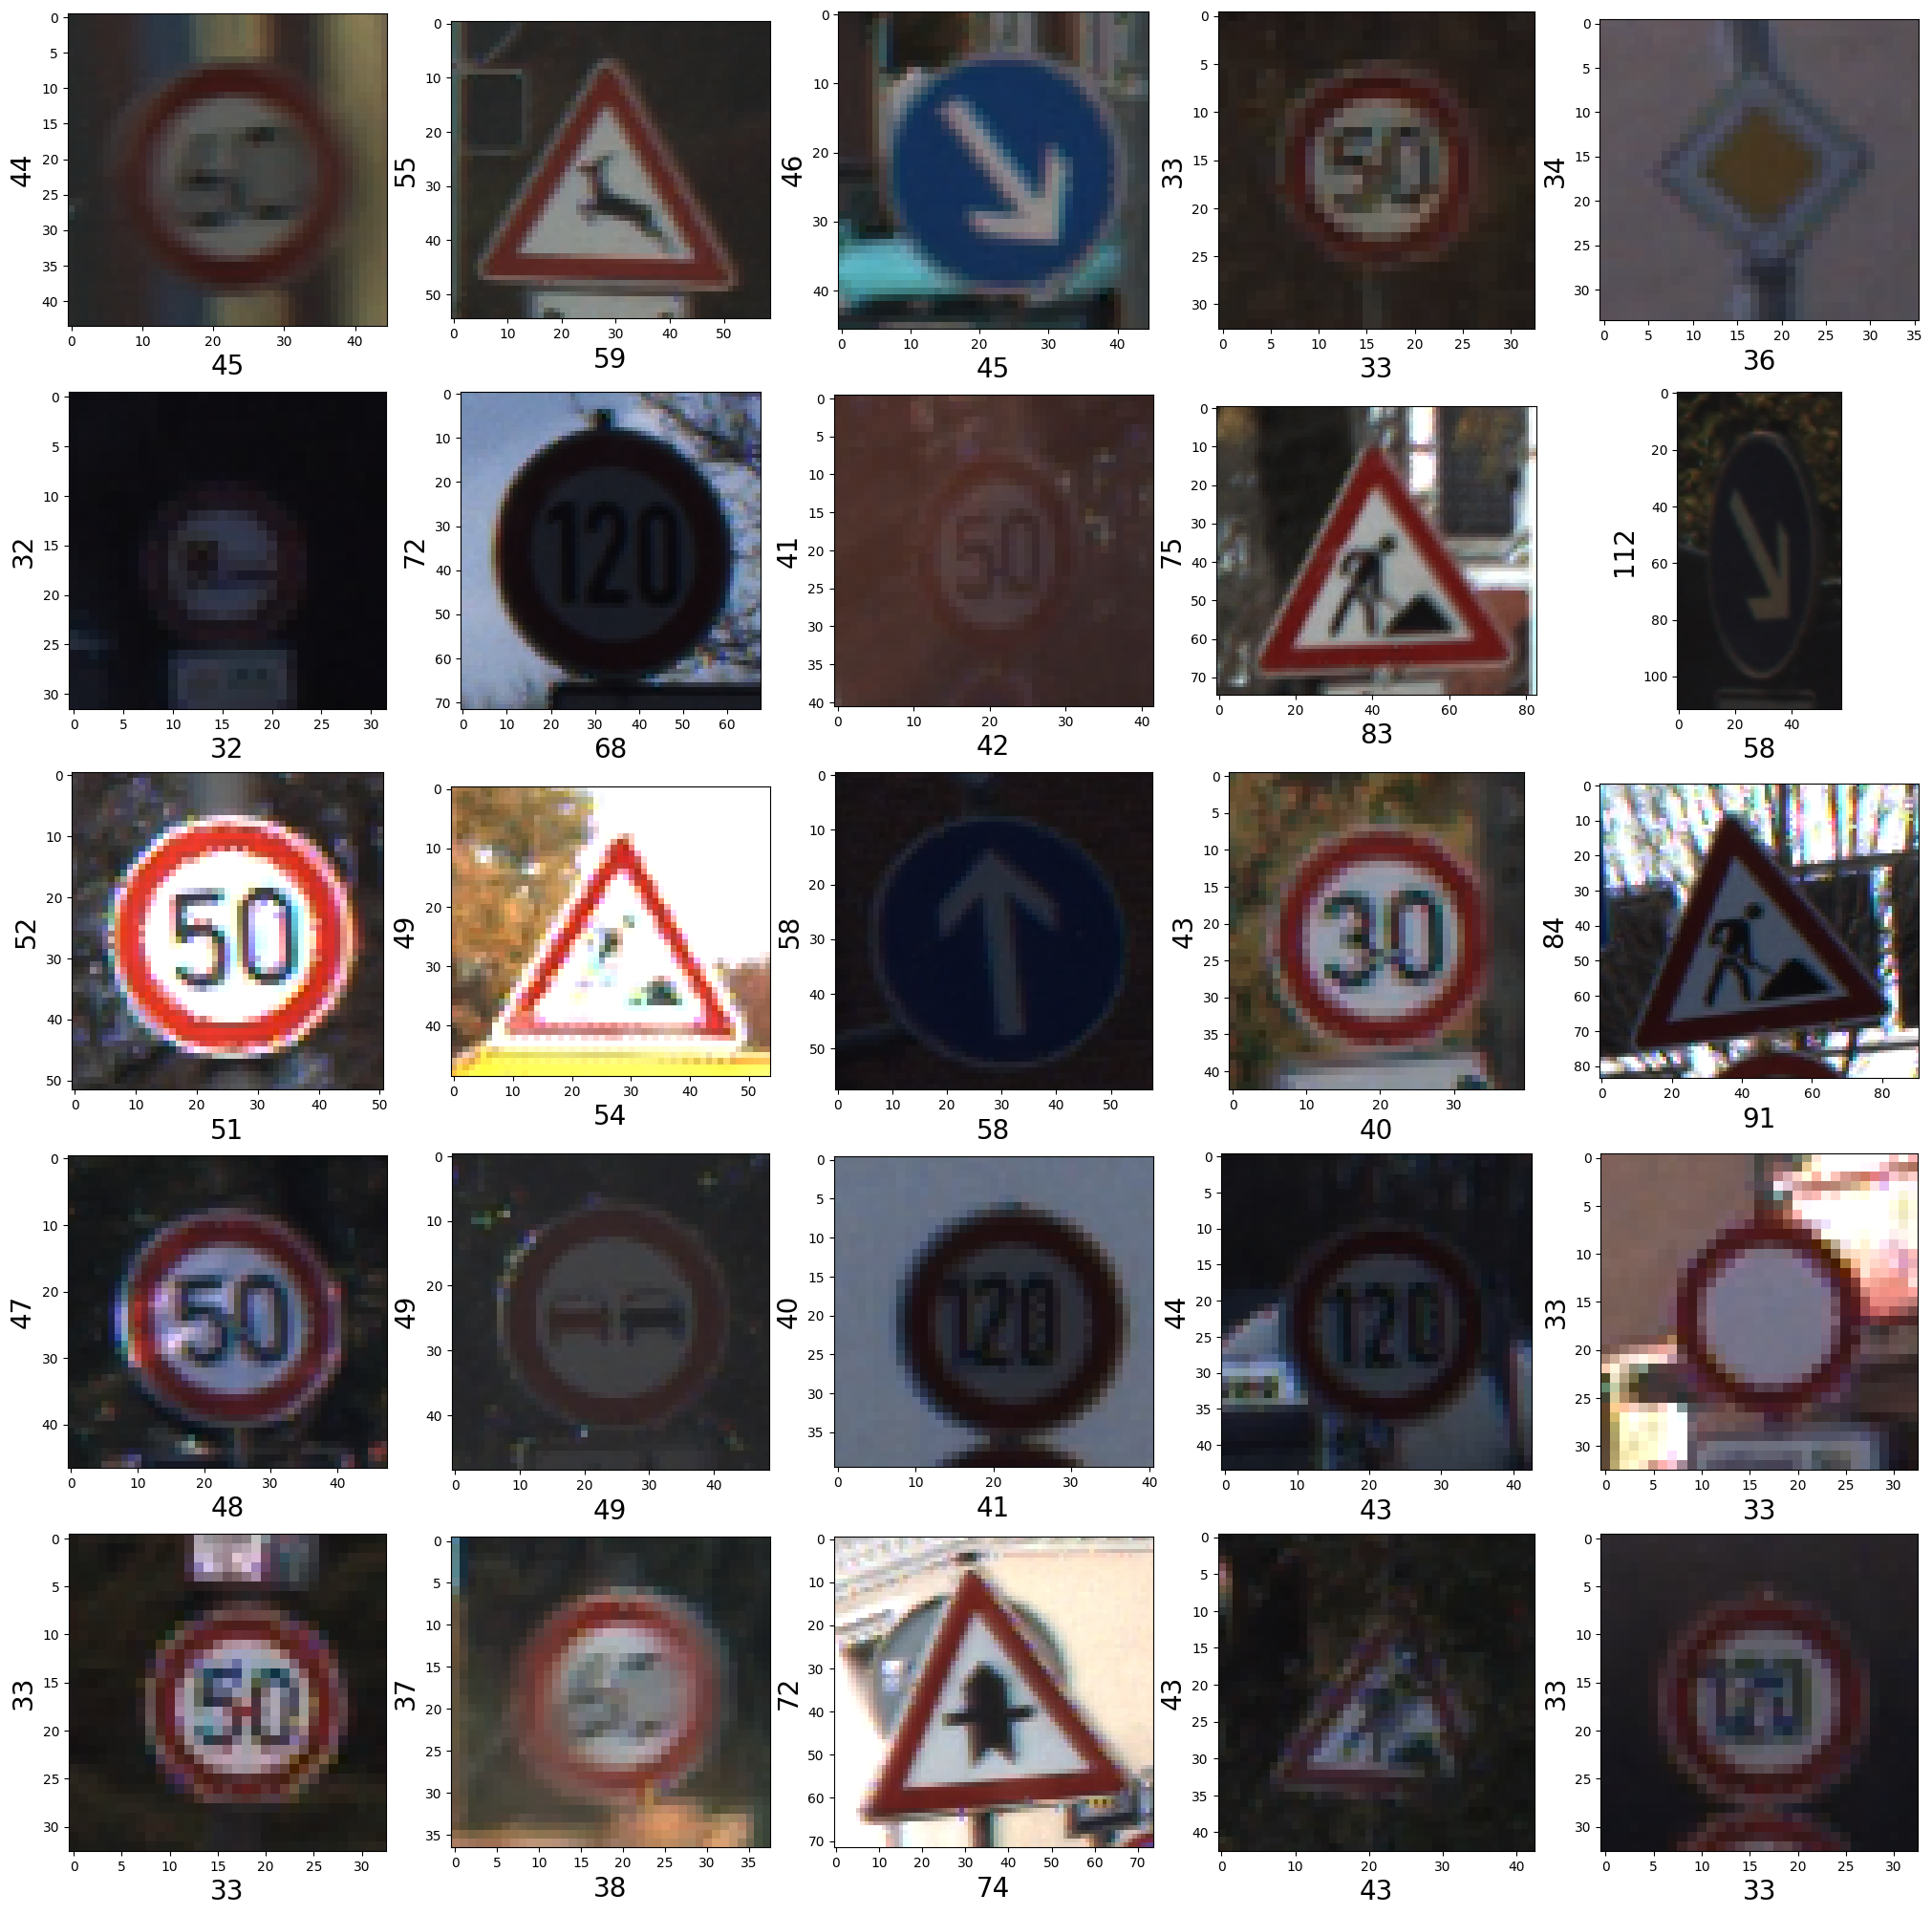

In [ ]:
import random

images_path = os.listdir(test_dir)

plt.figure(figsize=(25,25))


for i in range(1,26):

    plt.subplot(5,5,i)
    random_img_path = test_dir +'/'+ random.choice(images_path)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 20)
    plt.ylabel(rand_img.shape[0], fontsize = 20)

## ***Insights***

**Image Sizes Vary:** The images have different dimensions, so we need to resize them to a consistent shape for model training.

**Lighting and Quality Issues:** Some images are too dark or blurry, which  affect model performance brightness normalization or enhancement is required

## **Image Preprocessing**

In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## **Splitting the data into train and validation set**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 50, 50, 3)
X_valid.shape (11763, 50, 50, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## **One hot encoding the labels**

In [ ]:
import tensorflow.keras as keras

y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## **Model Building**

## **CNN Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

model = Sequential()

#1st layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = (50,50,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#3rd layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

#Dense layer
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(43, activation = 'softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,395 (829.67 KB)

 Trainable params: 212,395 (829.67 KB)

 Non-trainable params: 0 (0.00 B)

## **Augmenting the data and training the model**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.1300 - loss: 3.2475 - val_accuracy: 0.4806 - val_loss: 1.7468
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.3889 - loss: 1.9517 - val_accuracy: 0.6429 - val_loss: 1.1199
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.5044 - loss: 1.4992 - val_accuracy: 0.7469 - val_loss: 0.7896
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.5915 - loss: 1.2080 - val_accuracy: 0.8375 - val_loss: 0.5594
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.6450 - loss: 1.0546 - val_accuracy: 0.8918 - val_loss: 0.4023
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.6996 - loss: 0.9008 - val_accuracy: 0.9241 - val_loss: 0.2867
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.7333 - loss: 0.7943 - val_accuracy: 0.9393 - val_loss: 0.2381
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.7560 - loss: 0.7346 - 

368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


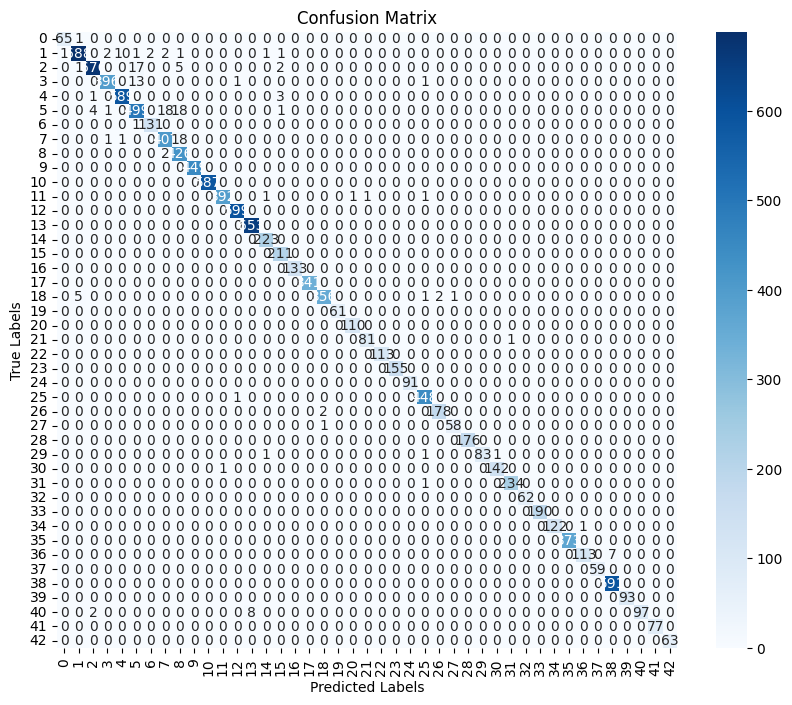

Test Loss: 0.0561
Test Accuracy: 0.9854


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)
# Convert y_pred to multilabel-indicator format (one-hot encoded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_onehot = to_categorical(y_pred_classes, num_classes=NUM_CATEGORIES)


# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
from sklearn.metrics import classification_report

# Convert y_val to multiclass format
y_val_classes = np.argmax(y_val, axis=1)

print(classification_report(y_val_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.99      0.97      0.98       709
           2       0.99      0.96      0.98       701
           3       0.99      0.96      0.98       411
           4       0.98      0.99      0.99       593
           5       0.94      0.92      0.93       541
           6       0.98      0.99      0.99       132
           7       0.95      0.95      0.95       427
           8       0.91      1.00      0.95       428
           9       1.00      1.00      1.00       449
          10       1.00      1.00      1.00       587
          11       1.00      0.99      0.99       396
          12       1.00      1.00      1.00       599
          13       0.99      1.00      0.99       653
          14       0.99      1.00      0.99       223
          15       0.97      1.00      0.98       211
          16       1.00      1.00      1.00       133
          17       1.00    

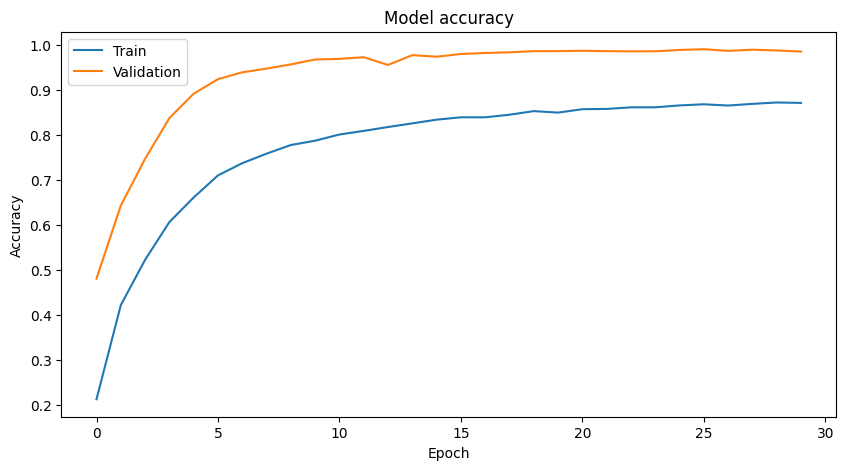

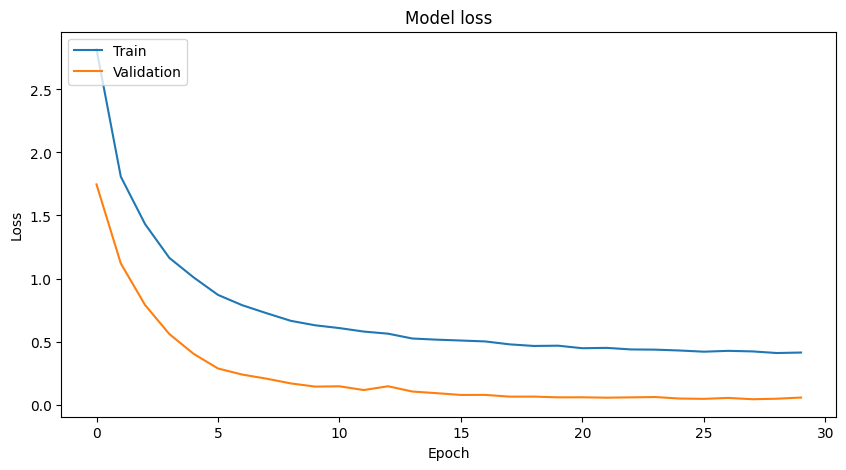

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save("model.h5")

## **Testing on test data**

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [ ]:
test_path = '/content/drive/MyDrive/sign_detection/Test'
test_img = sorted(os.listdir(test_path))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os

model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# Provide the full path to your image
image_path = "/content/drive/MyDrive/00123.png"

image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not read image from {image_path}. Please check the file path and ensure the image exists.")
else:
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((50, 50))
    expand_input = np.expand_dims(resize_image, axis=0)
    input_data = np.array(expand_input)
    input_data = input_data / 255

    pred = loaded_model.predict(input_data)
    result = pred.argmax()
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
8


## ***Insights***

**High Model Performance:** The model achieved a Test Accuracy of 98.54% and a Test Loss of 0.0561, indicating excellent performance on unseen data.


**Effective Generalization:** The high accuracy shows the model has generalized well and is not overfitting, effectively identifying traffic signs in test images.


**Reliable Predictions:** Consistently correct predictions on test samples confirm the model’s suitability for real-world deployment in traffic sign recognition tasks.

## **Transfer Learning**

**Transfer Learning** is a deep learning technique where a pre-trained model (trained on a large dataset like ImageNet) is adapted to a new but related task.

Instead of training from scratch, we reuse learned features, fine-tune some layers, and train only the classifier, saving time and improving accuracy, especially for small datasets

## **DenseNet 121**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

from tensorflow.keras.models import Model

#  the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(43, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 56, 56, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 25, 25,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 25, 25,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 25, 25,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 27, 27,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 13, 13,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 13, 13,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 13, 13,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 13, 13,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 13, 13,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 13, 13,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 13, 13,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 13, 13,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 13, 13,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 13, 13,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 13, 13,    │     12,288 │ conv2_block2_0_r

 Total params: 8,131,179 (31.02 MB)

 Trainable params: 8,047,531 (30.70 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))


# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 330s 218ms/step - accuracy: 0.7222 - loss: 1.0376 - val_accuracy: 0.8707 - val_loss: 0.5138
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 97s 51ms/step - accuracy: 0.9709 - loss: 0.1120 - val_accuracy: 0.9651 - val_loss: 0.1542
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.9817 - loss: 0.0707 - val_accuracy: 0.8876 - val_loss: 0.4499
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.9778 - loss: 0.0966 - val_accuracy: 0.9809 - val_loss: 0.0737
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.9926 - loss: 0.0296 - val_accuracy: 0.9762 - val_loss: 0.1056
Test Loss: 0.1056
Test Accuracy: 0.9762


368/368 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


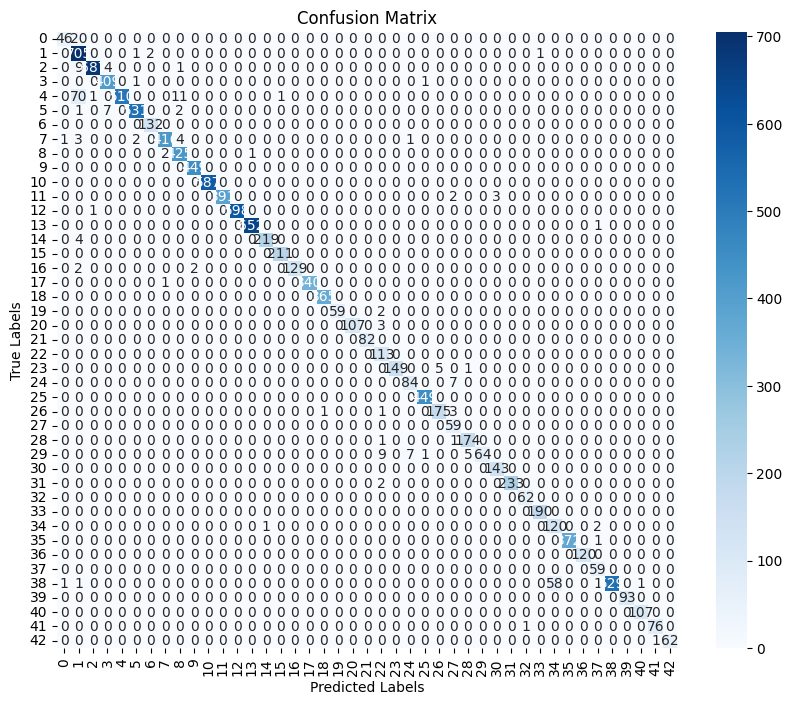

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
print(classification_report(y_val_classes, y_pred_classes))


              precision    recall  f1-score   support

           0       0.96      0.70      0.81        66
           1       0.87      0.99      0.93       709
           2       1.00      0.98      0.99       701
           3       0.97      1.00      0.98       411
           4       1.00      0.86      0.92       593
           5       0.99      0.98      0.99       541
           6       0.99      1.00      0.99       132
           7       0.99      0.97      0.98       427
           8       0.96      0.99      0.98       428
           9       1.00      1.00      1.00       449
          10       1.00      1.00      1.00       587
          11       1.00      0.99      0.99       396
          12       1.00      1.00      1.00       599
          13       1.00      1.00      1.00       653
          14       1.00      0.98      0.99       223
          15       1.00      1.00      1.00       211
          16       1.00      0.97      0.98       133
          17       1.00    

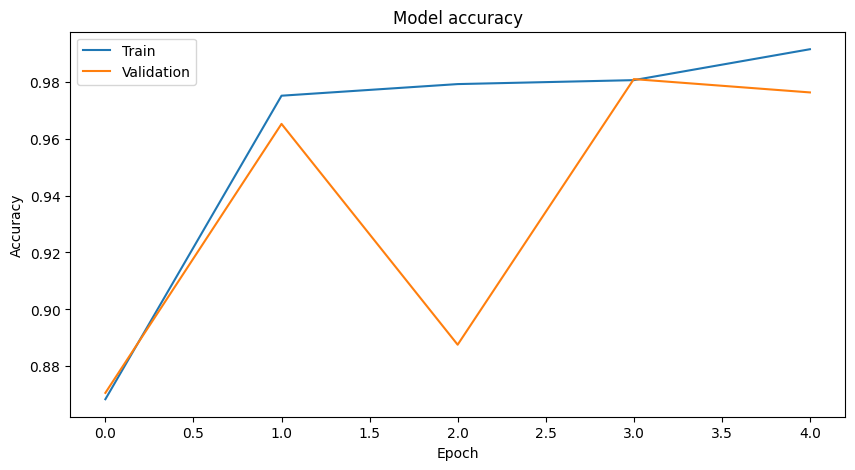

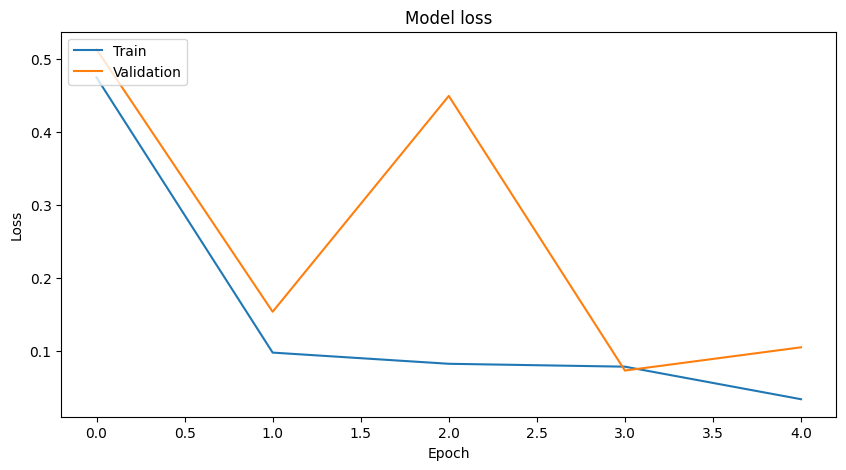

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save("model_Densenet.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_Densenet.h5')

In [ ]:
test_path = '/content/drive/MyDrive/sign_detection/Test'
test_img = sorted(os.listdir(test_path))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os

model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# Provide the full path to your image
image_path = "/content/drive/MyDrive/00123.png"

image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print(f"Error: Could not read image from {image_path}. Please check the file path and ensure the image exists.")
else:
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((50, 50))
    expand_input = np.expand_dims(resize_image, axis=0)
    input_data = np.array(expand_input)
    input_data = input_data / 255

    pred = loaded_model.predict(input_data)
    result = pred.argmax()
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
8


## MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# base MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(43, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 25, 25,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 25, 25,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 25, 25,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 25, 25,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 25, 25,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 25, 25,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 25, 25,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 25, 25,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 25, 25,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 25, 25,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 25, 25,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 27, 27,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 13, 13,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 13, 13,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 13, 13,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 13, 13,    │      2,304 │ block_1_depthwis

 Total params: 3,613,803 (13.79 MB)

 Trainable params: 3,579,691 (13.66 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.9327 - loss: 0.2279 - val_accuracy: 0.5947 - val_loss: 2.5157
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.9646 - loss: 0.1299 - val_accuracy: 0.4151 - val_loss: 8.7425
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9678 - loss: 0.1133 - val_accuracy: 0.8304 - val_loss: 0.9954
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9801 - loss: 0.0778 - val_accuracy: 0.7876 - val_loss: 2.0839
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9807 - loss: 0.0714 - val_accuracy: 0.6316 - val_loss: 3.1149


In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss: 3.1149
Test Accuracy: 0.6316


368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


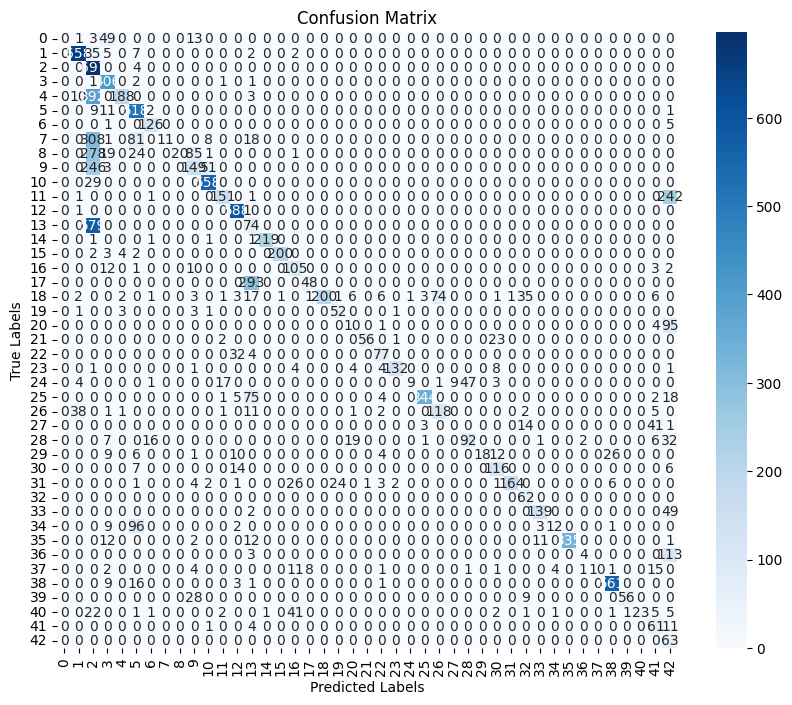

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.92      0.93      0.92       709
           2       0.27      0.99      0.42       701
           3       0.73      0.99      0.84       411
           4       0.95      0.32      0.48       593
           5       0.68      0.96      0.79       541
           6       0.85      0.95      0.90       132
           7       1.00      0.03      0.05       427
           8       1.00      0.05      0.09       428
           9       0.49      0.33      0.40       449
          10       0.90      0.95      0.92       587
          11       0.86      0.38      0.53       396
          12       0.89      0.98      0.94       599
          13       0.14      0.11      0.12       653
          14       1.00      0.98      0.99       223
          15       1.00      0.95      0.97       211
          16       0.55      0.79      0.65       133
          17       0.84    

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_val to multiclass format if it's one-hot encoded
if y_val.ndim == 2 and y_val.shape[1] > 1:
    y_val_classes = np.argmax(y_val, axis=1)
else:
    y_val_classes = y_val

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val_classes, y_pred_classes))

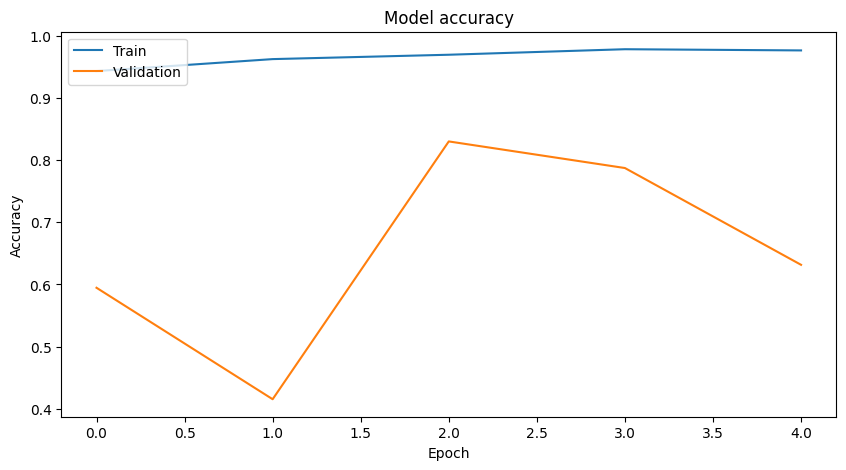

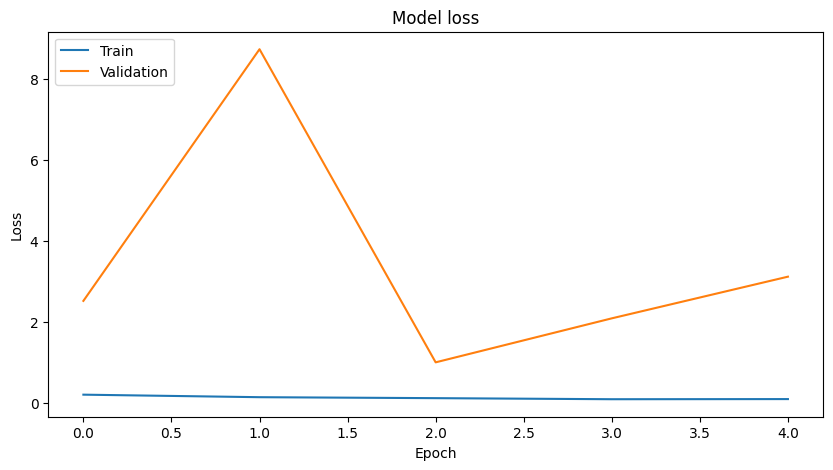

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save("model_MobileNetV2.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_MobileNetV2.h5')

In [ ]:
test_path = '/content/drive/MyDrive/sign_detection/Test'
test_img = sorted(os.listdir(test_path))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os

model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# Provide the full path to your image
image_path = "/content/drive/MyDrive/00123.png"

image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not read image from {image_path}. Please check the file path and ensure the image exists.")
else:
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((50, 50))
    expand_input = np.expand_dims(resize_image, axis=0)
    input_data = np.array(expand_input)
    input_data = input_data / 255

    pred = loaded_model.predict(input_data)
    result = pred.argmax()
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
8


## ***Insights***

CNN demonstrates the highest accuracy and lowest loss, making it the top performer for classifying traffic signs effectively.


DenseNet121 offers competitive accuracy but requires more resources than CNN, making it a strong alternative.


MobileNetV2 is more resource-efficient but lags in accuracy and reliability, making it less suitable for this task.

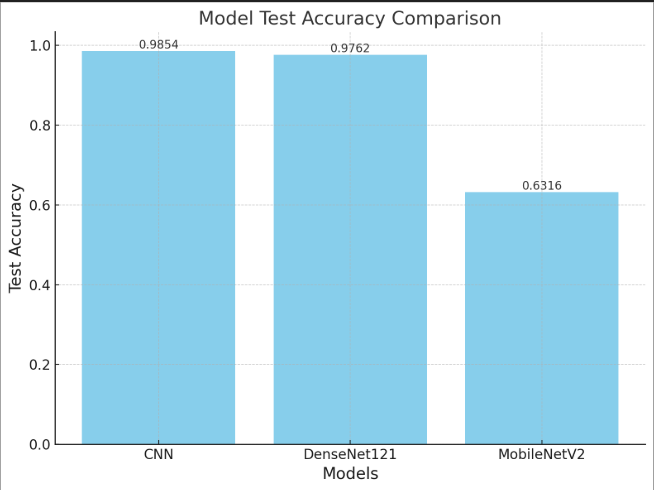

In [3]:
from IPython.display import Image
Image('/content/test cc.png')

## **Insights**

CNN outperforms all models with the highest test accuracy of 99.32%, indicating exceptional performance in classifying the data.

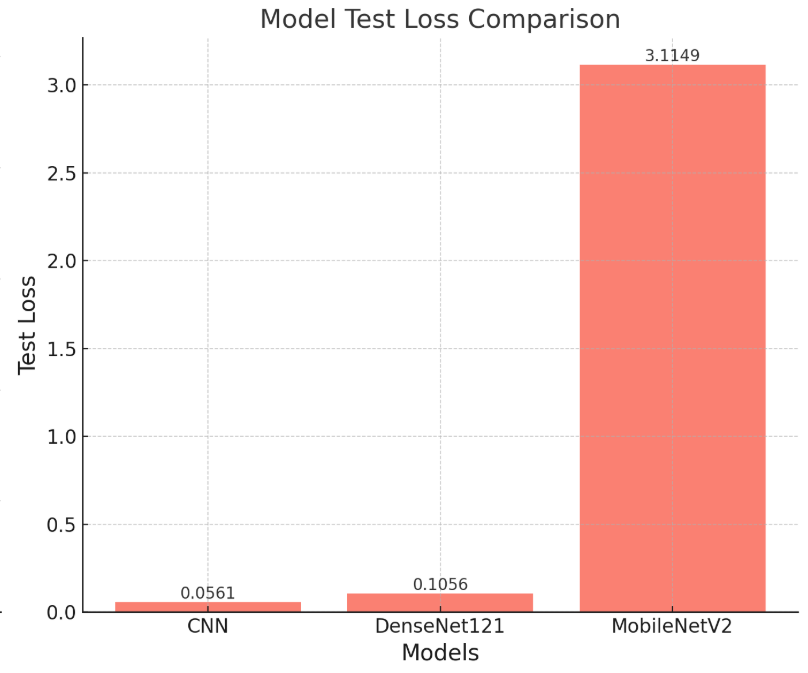

In [4]:
from IPython.display import Image
Image('/content/test loss.png')

## ***Insights***

CNN has the lowest test loss (0.0561), indicating the most accurate and confident predictions among the models.

## **Challenges Faced**

**Data Imbalance:** The dataset had a significant imbalance making it difficult for the model to learn minority class patterns effectively.



**Model Selection and Optimization:** Choosing the best model architecture (CNN, DenseNet121, MobileNetV2) and optimizing hyperparameters for each model was challenging and time-consuming.



**Training Time and Computational Limitations:** Models like DenseNet121 had long training times and high memory requirements, making it difficult without a high-end GPU.

## **Final Recommendation:**

**Deploy the CNN Model** – It achieved the highest accuracy (*98.54%*) and lowest loss (*0.0561%*), making it the most reliable and efficient choice for traffic sign classification, especially with limited computational resources.


**Add Real**-time Functionality – Integrate the model with a camera feed to detect and classify traffic signs in real time using OpenCV.

**Optimize for Deployment** – Convert the CNN model to a lightweight format to ensure fast inference on low-resource devices like Raspberry Pi or mobile platforms.


**Further Improvements (Optional)**:

Implement data augmentation if training time allows, to improve robustness.


Use confusion matrix and classification reports to analyze misclassifications and refine the model if needed.